# The Linear Regression Model and Softmax Regression
## Handwritten Digit Classifier
### Itamar Yuran

#### Linear regression is a fundamental method in machine learning, often used for regression tasks. In this case, we are applying it as a classifier for handwritten digit recognition on the MNIST dataset.

#### The linear regression model takes the pixel values of the images as input features and tries to learn a set of weights that, when multiplied with these features, result in an output that represents the predicted class of the handwritten digit.

#### Mathematically, the linear regression output (y_pred) is determined by the weighted sum of inputs (X) and a bias term. The weight of each input is determined during the training process using gradient descent.

#### The training process involves iteratively updating the weights to minimize the mean squared error between the predicted outputs and the actual labels. The model is trained over multiple epochs, and the weights are adjusted to improve accuracy.

#### In this implementation, I created a simple linear regression model from scratch using NumPy. The MNIST dataset, consisting of 70,000 handwritten digits, was used for training and testing. The pixel values of the images were normalized, and a bias term was added to the features.

#### Softmax Regression, on the other hand, extends the capabilities of logistic regression to handle multiple classes. It is particularly suited for classification problems where the output consists of multiple classes. Softmax regression uses the softmax activation function to produce a probability distribution over the classes, ensuring that the predicted probabilities sum up to 1.

#### The Softmax Regression model is trained using gradient descent to optimize the cross-entropy loss function. During training, it adjusts the weights and biases to minimize the difference between the predicted probabilities and the actual labels.

#### The goal is to learn a set of weights that can accurately classify the handwritten digits based on their pixel values.


In [1]:
# Importing the necessary libraries

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Fetching the data

mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [3]:
# Dividing the data to training set and test set

train_size = 60000
test_size = 10000

X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=2)


In [4]:
# Convert labels to one-hot vectors
def one_hot_encode(labels, num_classes):
    encoded_labels = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        label = int(label)
        encoded_labels[i, label] = 1
    return encoded_labels

# Preprocessing the data
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x = X_train.copy()
y = y_train.copy()
x_t = X_test.copy()
y_t = y_test.copy()

# Normalize features and add bias term
x = x.astype(float) / 255.0
x = np.insert(x, 0, 1, axis=1)
x_t = x_t.astype(float) / 255.0
x_t = np.insert(x_t, 0, 1, axis=1)

# One-hot encode 
y = one_hot_encode(y_train, 10)
y_t = one_hot_encode(y_test, 10)

# From here on we use the notations:
# x --->  train set
# y --->  train label
# x_t ->  test set
# y_t ->  test label



#### Each "input" is as I said an image of a digit. We will represent these in one single vector containing a value for every pixel of the image (and a bias term). 
#### The raw data we work on, looks like this:

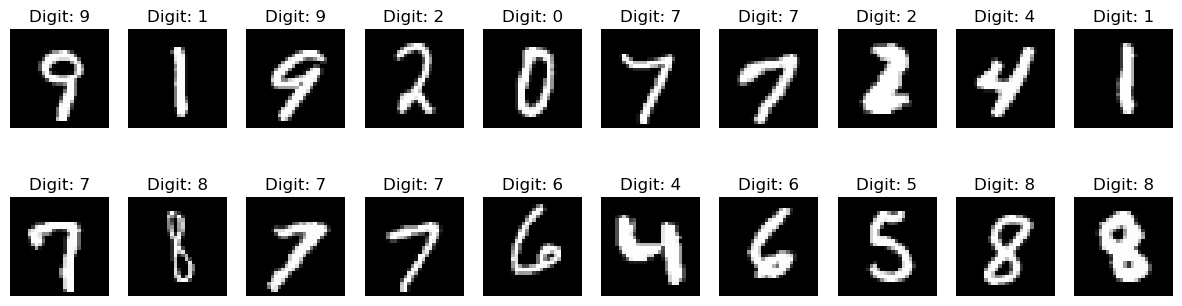

In [5]:
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(20):
    axes[i // 10, i % 10].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i // 10, i % 10].set_title('Digit: {}'.format(y_train[i]))
    axes[i // 10, i % 10].axis('off')

plt.show()


In [6]:
# Quick check that the data is shapes as we pleased

print(f"training set shape:       {x.shape}")
print(f"training label shape:     {y.shape}")
print(f"test set shape:           {x_t.shape}")
print(f"test label shape:         {y_t.shape}")


training set shape:       (60000, 785)
training label shape:     (60000, 10)
test set shape:           (10000, 785)
test label shape:         (10000, 10)


#### The function below will extract the interesting data out of our model


In [7]:
def get_stats(cm):
    
    TP = np.diagonal(cm)
    TN = np.sum(np.delete(np.delete(cm, np.arange(10), axis=0), np.arange(10), axis=1))
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP

    total_predictions = np.sum(cm)

    accuracy = (np.sum(TP) + TN) / total_predictions
    sensitivity = np.sum(TP) / (np.sum(TP) + np.sum(FN))
    selectivity = TN / (TN + np.sum(FP))

    row_sums = np.sum(cm, axis=1)
    col_sums = np.sum(cm, axis=0)

    percentage_TP = TP / row_sums * 100
    if np.sum(np.delete(np.delete(cm, np.arange(10), axis=0), np.arange(10), axis=1)) != 0:
        percentage_TN = TN / np.sum(np.delete(np.delete(cm, np.arange(10), axis=0), np.arange(10), axis=1)) * 100
    else:
        percentage_TN = 0 
    percentage_FP = FP / col_sums * 100
    percentage_FN = FN / row_sums * 100

    print("True Positives (TP):                ", np.round(TP, 2))
    print("Percentage of TP:                   ", np.round(percentage_TP, 2), "%")
    print("True Negatives (TN):                ", np.round(TN, 2))
    print("Percentage of TN:                   ", np.round(percentage_TN, 2), "%")
    print("False Positives (FP):               ", np.round(FP, 2))
    print("Percentage of FP:                   ", np.round(percentage_FP, 2), "%")
    print("False Negatives (FN):               ", np.round(FN, 2))
    print("Percentage of FN:                   ", np.round(percentage_FN, 2), "%")
    print("Accuracy:                           ", np.round(accuracy * 100, 2), "%" )
    print("Sensitivity (True Positive Rate):   ", np.round(sensitivity * 100, 2), "%" )
    print("Selectivity (True Negative Rate):   ", np.round(selectivity * 100, 2), "%" )


In [8]:
# Plotting the confusion matrix

def plot_cm(cm):
    class_labels = [f'Digit {i}' for i in range(10)]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap="Blues", interpolation="nearest")

    cbar = plt.colorbar()
    cbar.set_label('Count', rotation=270, labelpad=15)

    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)

    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.show()


In [9]:
# Function for plotting each digits confusion matrix

def digits_cm(cm):
    confusion_matrices = {}
    for digit in range(10): 
        TP = cm[digit][digit]
        FP = np.sum(cm[:,digit]) - TP
        FN = np.sum(cm[digit,:]) - TP
        TN = np.sum(cm) - TP - FP - FN
        cm_digit = np.array([[TP,FN],[FP,TN]])
        confusion_matrices[digit] = cm_digit

    fig, axes = plt.subplots(2, 5, figsize=(15, 7))

    for i, (digit, matrix) in enumerate(confusion_matrices.items()):
        ax = axes[i // 5, i % 5]
        ax.imshow(matrix, cmap='Blues', interpolation='nearest')

        # Add text annotations
        for j in range(2):
            for k in range(2):
                ax.text(k, j, str(matrix[j, k]), ha='center', va='center', color='black')

        ax.set_title(f"Digit {digit}")
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['FP', 'TN']) 
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['TP', 'FN'])  

    plt.tight_layout()
    plt.show()
    
    

In [10]:
def plot_loss(model, loss):
    plt.plot(range(1, model.epochs + 1), model.losses, "ro",label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel(loss)
    plt.title('Training Error over Epochs')
    plt.legend()
    plt.show()


In [11]:

class SoftmaxRegression:
    
    def __init__(self, learning_rate=0.5, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.classes = None
        self.losses = []

        # The Softmax function. Gets the exponent of the features then normalise it to have a sum of 1
    def softmax(self, x):
        expo = np.exp(x)
        for i in range(len(x)):
            expo[i] /= np.sum(expo[i])
        return expo

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(np.argmax(y, axis=1))
        n_classes = len(self.classes)
       
        # Initialize weights
        self.weights = np.zeros((n_features, n_classes))

        # Training
        for epoch in range(self.epochs):
            scores = np.dot(X, self.weights)
            probs = self.softmax(scores)

            # Compute cross-entropy loss
            loss = -np.sum(y * np.log(probs)) / n_samples
            self.losses.append(loss)

            # Compute gradient
            grad = np.dot(X.T, (probs - y)) / n_samples

            # Update weights 
            self.weights -= self.learning_rate * grad

    def predict(self, X):
        scores = np.dot(X, self.weights)
        probs = self.softmax(scores)
        return np.argmax(probs, axis=1)


#### Let us now check what are the best learning rate and epochs number

In [ ]:
learning = [0.05,0.01,0.005]
epoches = [100,300,500]

for learn in learning:
    for e in epoches:
        s = SoftmaxRegression(learn,e)
        s.fit(x,y)
        
        y_pred = s.predict(x_t)
        true_labels = np.argmax(y_t, axis = 1)
        accuracy = np.mean(y_pred == true_labels)
        print(f"Rate: {learn}   Epochs: {e}   Accuracy: {accuracy * 100:.2f}%")


In [14]:
soft_model = SoftmaxRegression(0.05,500)
soft_model.fit(x,y)
y_pred_soft = soft_model.predict(x_t)

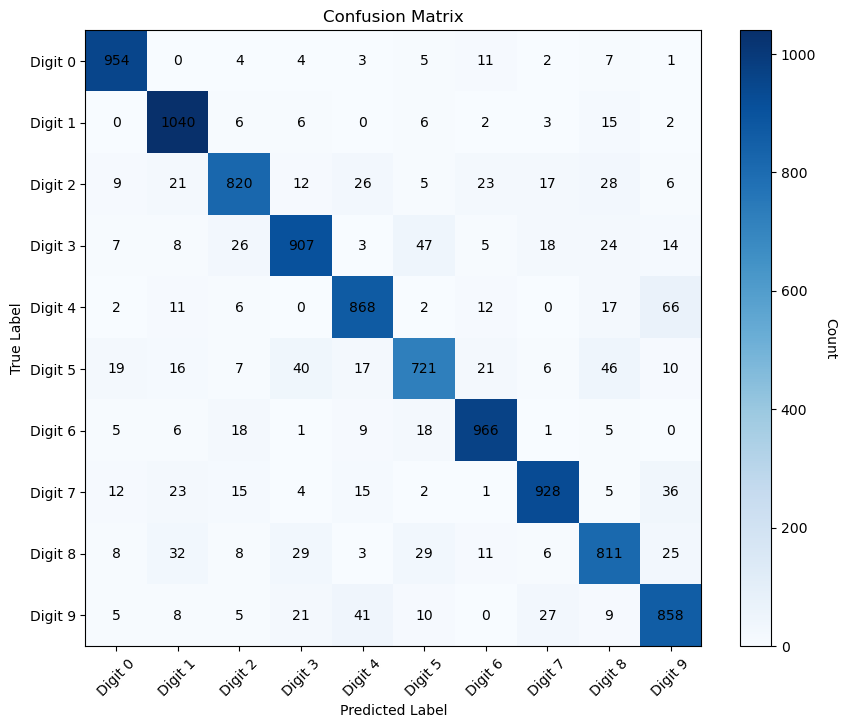

In [15]:
cm_soft = confusion_matrix(true_labels, y_pred_soft)
plot_cm(cm_soft)

#### The cell below shows each digit's confusion matrix, as you can see, most of their weight is in TN, thats because these are all the instances that are not that specific digit, and were'nt classified as one, meaning it is ~90% of the data

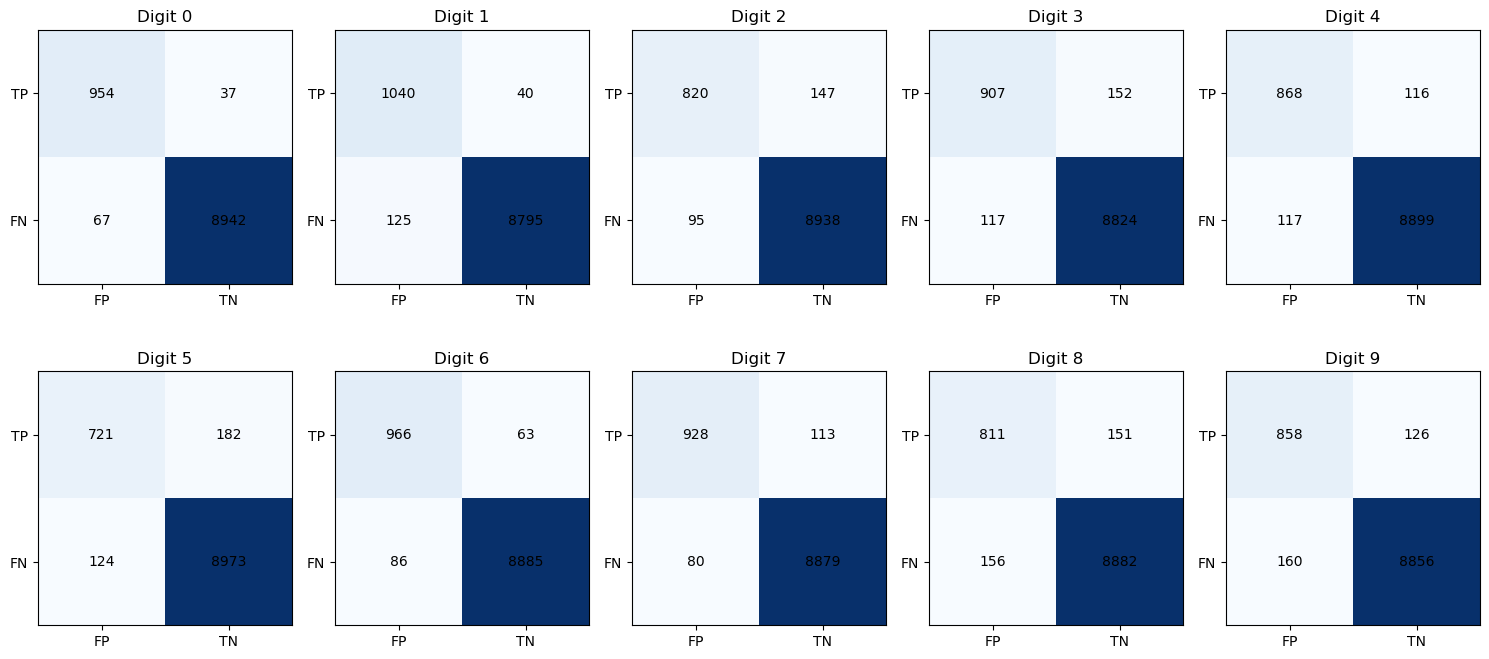

In [16]:
digits_cm(cm_soft)

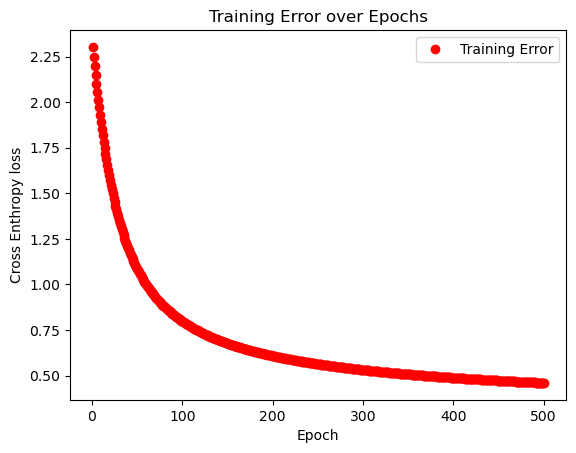

In [17]:
plot_loss(soft_model, "Cross Enthropy loss")


#### True Positives (TP) represent the number of correctly predicted instances of each digit class. It indicates the model's ability to accurately identify positive instances.

#### True Negatives (TN) count the number of correctly predicted instances that are not part of the target class. In the context of the MNIST dataset, TN accounts for the accurate classification of digits that are not the predicted class.

#### False Positives (FP) indicate the number of instances that were incorrectly classified as positive instances. In the context of handwritten digit classification, FP refers to instances where the model incorrectly identifies a digit as belonging to a different class.

#### False Negatives (FN) count the number of instances that were incorrectly classified as negative instances. In the MNIST dataset, FN represents instances where the model fails to identify a digit that belongs to the predicted class.


In [18]:
get_stats(cm_soft)

True Positives (TP):                 [ 954 1040  820  907  868  721  966  928  811  858]
Percentage of TP:                    [96.27 96.3  84.8  85.65 88.21 79.84 93.88 89.15 84.3  87.2 ] %
True Negatives (TN):                 0
Percentage of TN:                    0 %
False Positives (FP):                [ 67 125  95 117 117 124  86  80 156 160]
Percentage of FP:                    [ 6.56 10.73 10.38 11.43 11.88 14.67  8.17  7.94 16.13 15.72] %
False Negatives (FN):                [ 37  40 147 152 116 182  63 113 151 126]
Percentage of FN:                    [ 3.73  3.7  15.2  14.35 11.79 20.16  6.12 10.85 15.7  12.8 ] %
Accuracy:                            88.73 %
Sensitivity (True Positive Rate):    88.73 %
Selectivity (True Negative Rate):    0.0 %


In [19]:
def plot_prob(num):
    predicted_probabilities = s.softmax(np.dot(x_t, s.weights))
    true_label = np.argmax(y_t[num])

    fig, axes = plt.subplots(1, 2, figsize=(9, 3))  

    axes[0].imshow(X_test[num].reshape(28, 28), cmap='gray')
    axes[0].axis('off')

    predicted_label = np.argmax(predicted_probabilities[num])
    axes[0].text(0.5, -0.15, f'True Label: {true_label}, Predicted Label: {predicted_label}', transform=axes[0].transAxes, ha='center')

    bar_positions = np.arange(10)
    bars = axes[1].barh(bar_positions, predicted_probabilities[num], color='blue')

    for bar, prob in zip(bars, predicted_probabilities[num]):
        axes[1].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{prob:.2f}', va='center', color='black')

    axes[1].set_yticks(bar_positions)
    axes[1].set_yticklabels(np.arange(10))
    axes[1].set_xlim(0, 1) 
    axes[1].set_xlabel('Probability')
    axes[1].set_title('Predicted Probabilities')

    plt.tight_layout()
    plt.show()


#### In the cell below, we can see the probability of each value, the model computed for an instance to be classified as

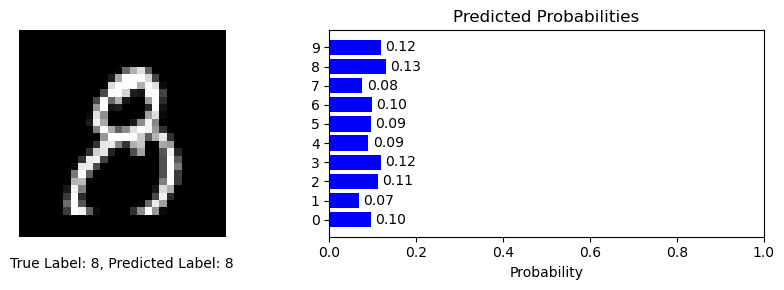

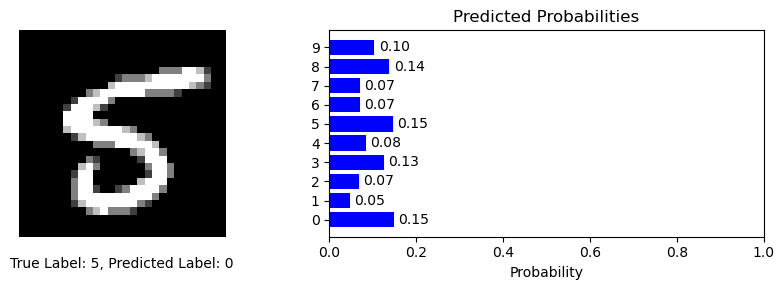

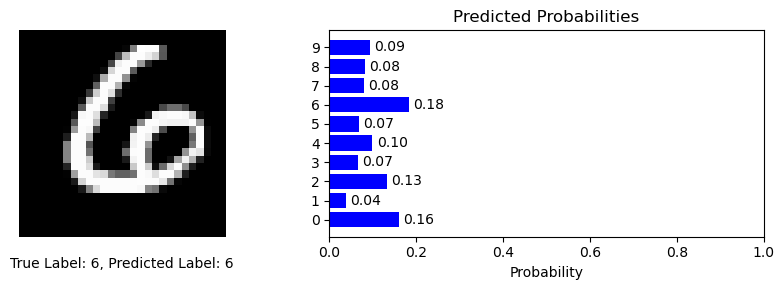

In [20]:
for i in range(3):
    plot_prob(i)

### Let us now take a look over the classifications.
#### In the plot below there are 100 instances from the test set, above each one we have the models prediction to that instance as well as that instance's label

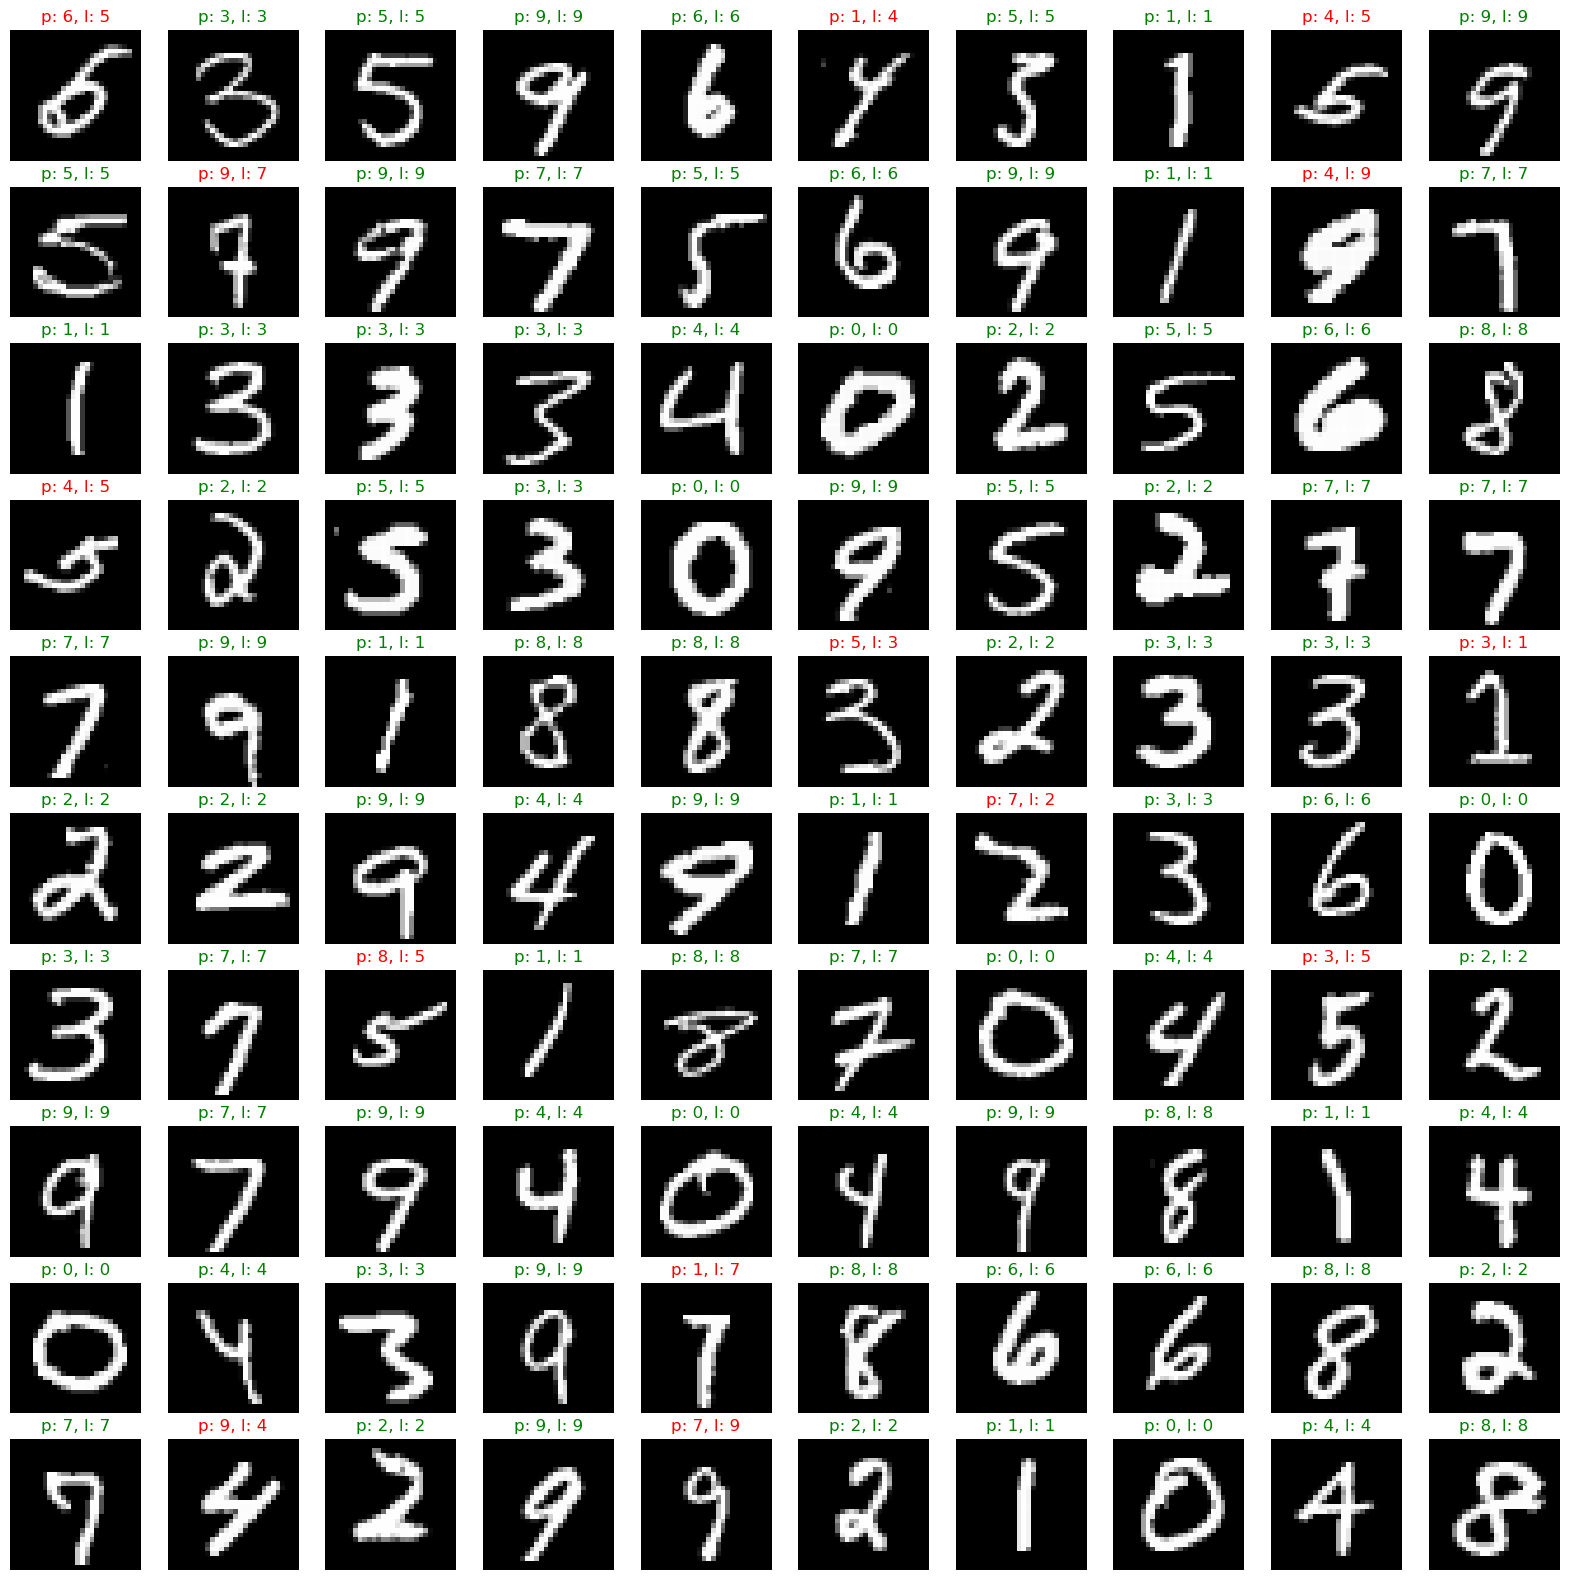

In [21]:

fig, axes = plt.subplots(10, 10, figsize=(20, 20))

for i in range(100):
    img = X_test[100 + i].reshape(28, 28)
    pred_label = y_pred_soft[100 + i]
    true_label = true_labels[100 + i]

    color = 'green' if pred_label == true_label else 'red'

    axes[i // 10, i % 10].imshow(img, cmap='gray')
    axes[i // 10, i % 10].set_title('p: {}, l: {}'.format(pred_label, true_label), color=color)
    axes[i // 10, i % 10].axis('off')

plt.show()


### Linear Regression

#### First of all let's define the problem properly. The linear regression model is usualy used to predict and not to classify. It returns a predicted Y value for each instance x. Therefore, it is not the most suitble model for classifying hand-Written digits.
#### In order to adapt the model to our mission, we did as such:
#### when training the model, we noted the target label as a one hot vector, in that way, for each instace X we got ten values for Y as an output. This modification helps us by giving us a way to measure how wrong was the model in some classification. The one-hot vector, which is a serie of zeros and a one in the index of the instances label, and the result vector, which is of the same size only filled with different values the model predicted, gives us together a great way of measuring the extent of "wrongness". By taking the difference between these two vectors in the power of two, we get a singel positiv value, that tells us how far was the prediction from the actual label. By deriving this function, we recive the gradient of that point. This derivative tells us how to change the weight vactor accordingly to minimise the error. By having this process over and over we minimise the error, and in other words, we find what is the best hypeplane we could have, that has the smallest sum of distances from the features.
#### Eventually, for classifying the instances, we multiply the test set with the weights we got from the trained model, that yields us with a vectore of ten floats, one for each digit. the classification takes the highest value in the vector, and determains that the its index is the classified digit


In [22]:
class linear_regression:
    
    def __init__(self,learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None 
        self.losses = []
    
    def fit(self,X,y):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_features,len(y[1])))
        # Training
        
        for epoch in range(self.epochs):
            y_pred = np.dot(X, self.weights)

            # Compute mean squared error loss
            loss = np.mean((y - y_pred)**2)
            self.losses.append(loss)
            dW = 2 * np.dot(X.T, (y_pred - y)) / len(y)
            

            # Update weights
            self.weights -= self.learning_rate * dW
            
            
    def predict(self,X):
        y_pred_test = np.dot(X, self.weights)
        return y_pred_test
        

#### Let us now check what are the best learning rate and epochs number

In [ ]:
learning = [0.05,0.01,0.005]
epoches = [100,300,500]

for learn in learning:
    for e in epoches:
        l = linear_regression(learn,e)
        l.fit(x,y)
        
        y_pred = l.predict(x_t)
        true_labels = np.argmax(y_t, axis = 1)
        predicted_labels = np.argmax(y_pred, axis=1)
        accuracy = np.mean(predicted_labels == true_labels)
        print(f"Rate: {learn}   Epochs: {e}   Accuracy: {accuracy * 100:.2f}%")


In [23]:
linear_model = linear_regression(0.01,500)
linear_model.fit(x,y)

In [24]:
y_pred_linear = linear_model.predict(x_t)

#### This is how the result vector looks like. 

In [25]:
y_pred_linear[1]

array([ 0.07693686, -0.01470563, -0.13807486,  0.04009717,  0.02464705,
        0.91143432,  0.04005497, -0.17183652,  0.20704524,  0.08779824])

In [26]:
y_pred_linear = np.argmax(y_pred_linear,axis = 1)
true_labels = np.argmax(y_t, axis = 1)
cm_linear = confusion_matrix(true_labels, y_pred_linear)

In [27]:
get_stats(cm_linear)

True Positives (TP):                 [ 960 1050  760  900  853  592  961  913  740  805]
Percentage of TP:                    [96.87 97.22 78.59 84.99 86.69 65.56 93.39 87.7  76.92 81.81] %
True Negatives (TN):                 0
Percentage of TN:                    0 %
False Positives (FP):                [102 295  81 179 160  75 106 150 158 160]
Percentage of FP:                    [ 9.6  21.93  9.63 16.59 15.79 11.24  9.93 14.11 17.59 16.58] %
False Negatives (FN):                [ 31  30 207 159 131 311  68 128 222 179]
Percentage of FN:                    [ 3.13  2.78 21.41 15.01 13.31 34.44  6.61 12.3  23.08 18.19] %
Accuracy:                            85.34 %
Sensitivity (True Positive Rate):    85.34 %
Selectivity (True Negative Rate):    0.0 %


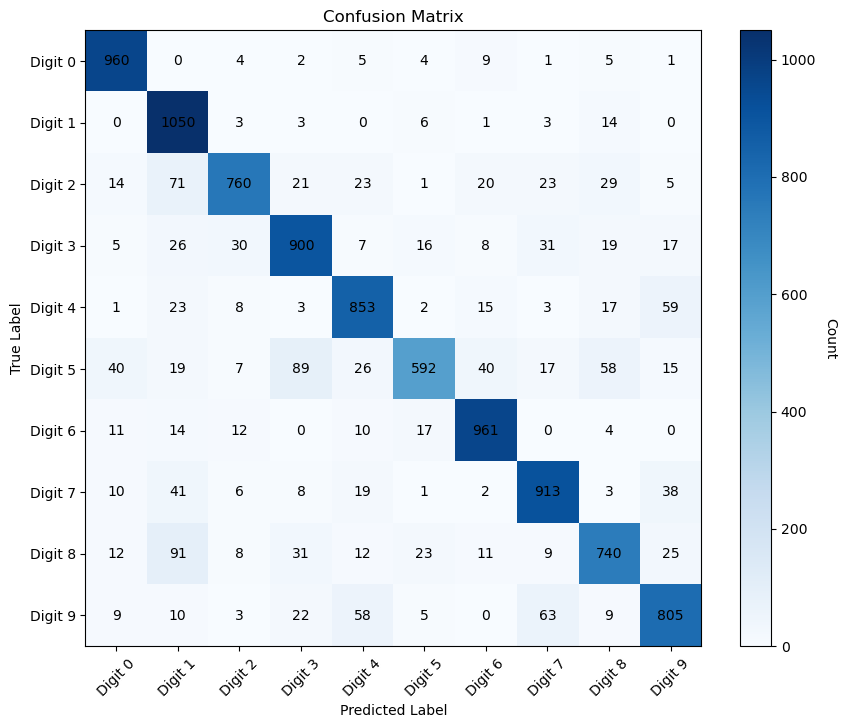

In [28]:
plot_cm(cm_linear)

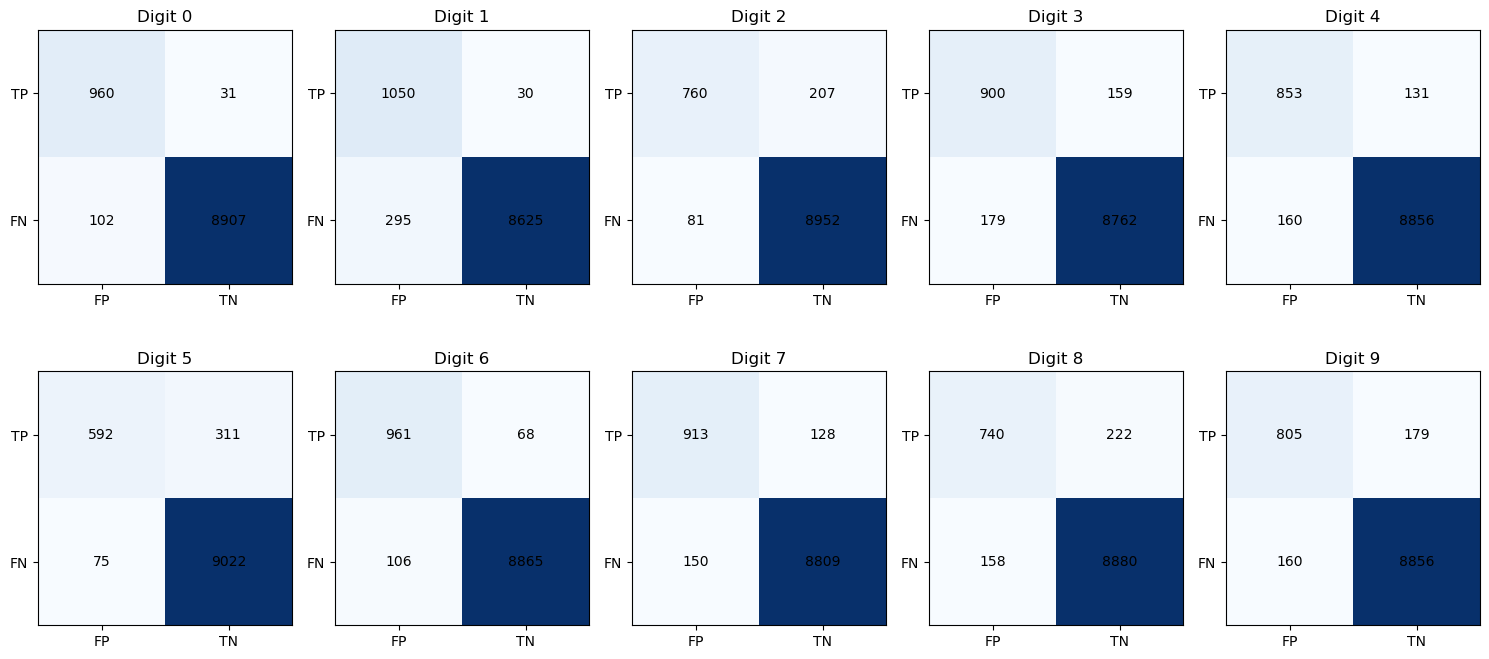

In [29]:
digits_cm(cm_linear)

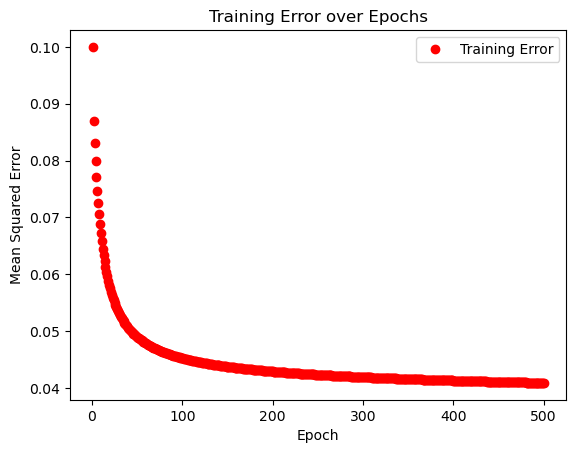

In [30]:
plot_loss(linear_model, "Mean Squared Error")

### Summing up
#### In this Assignment (and in the last one) we were asked to classify handwritten digits with three different machine learning models. Perceptron, Linear regression an Soft max.
#### All three of the models yielded about the same accuracy, around 88 percent
#### Perceptron - 91.1%
#### Linear regressiom - 85.34%
#### Soft max - 88.73%
#### This makes the perceptron I built the most accurate
#### Computation wise - the run time of three of the models was quite similar, The diffrence, was, that they started converging in different points, meaning reaching the "elbow" in the loss graph. the perceptorn reched there after a small amount of iterations, the linear model after about 50, and the softmax in a little less than 100 epochs.
#### With all that being said, the only adventage I can think of for the linear regression model, is that it was the most simple one to implement.
